In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
from tf_utils import load_dataset, random_mini_batches, convert_to_one_hot, predict

%matplotlib inline
np.random.seed(1)

### Problem statement: SIGNS Dataset

Built an algorithm that would facilitate communications from a speech-impaired person to someone who doesn't understand sign language.

- **Training set**: 1080 pictures (64 by 64 pixels) of signs representing numbers from 0 to 5 (180 pictures per number).
- **Test set**: 120 pictures (64 by 64 pixels) of signs representing numbers from 0 to 5 (20 pictures per number).

Note that this is a subset of the SIGNS dataset. The complete dataset contains many more signs.



In [16]:
# Loading the dataset
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

In [18]:
# Flatten the training and test images
X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0], -1).T
X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0], -1).T
# Normalize image vectors
X_train = X_train_flatten/255.
X_test = X_test_flatten/255.
# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 6)
Y_test = convert_to_one_hot(Y_test_orig, 6)

print ("number of training examples = " + str(X_train.shape[1]))
print ("number of test examples = " + str(X_test.shape[1]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (12288, 1080)
Y_train shape: (6, 1080)
X_test shape: (12288, 120)
Y_test shape: (6, 120)


In [19]:
def create_placeholders(n_x, n_y):
    """
    Creates the placeholders for the tensorflow session.
    Tips:
    - I used none because it let's us be flexible on the number of examples we will use for the placeholders.
      In fact, the number of examples during test/train is different.
    """

    X = tf.placeholder(tf.float32, shape=[n_x,None], name='X')
    Y = tf.placeholder(tf.float32, shape=[n_y,None], name='Y')
    
    return X, Y

In [21]:
def initialize_parameters():
    """
    Initializes parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [25, 12288]
                        b1 : [25, 1]
                        W2 : [12, 25]
                        b2 : [12, 1]
                        W3 : [6, 12]
                        b3 : [6, 1]
    """
            
    W1 = tf.get_variable('W1',[25,12288],initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b1 = tf.get_variable('b1',[25,1],initializer=tf.zeros_initializer())
    W2 = tf.get_variable('W2',[12,25],initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b2 = tf.get_variable('b2',[12,1],initializer=tf.zeros_initializer())
    W3 = tf.get_variable('W3',[6,12],initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b3 = tf.get_variable('b3',[6,1],initializer=tf.zeros_initializer())
 

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [23]:
def forward_propagation(X, parameters): 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    

    Z1 = tf.add(tf.matmul(W1,X), b1)                                
    A1 = tf.nn.relu(Z1)                                          
    Z2 = tf.add(tf.matmul(W2, A1), b2)                            
    A2 = tf.nn.relu(Z2)          
    Z3 = tf.add(tf.matmul(W3, A2), b3) 
    
    return Z3

In [25]:
def compute_cost(Z3, Y):
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits , labels = labels))
    
    return cost

In [26]:
tf.reset_default_graph()

with tf.Session() as sess:
    X, Y = create_placeholders(12288, 6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    print("cost = " + str(cost))

cost = Tensor("Mean:0", shape=(), dtype=float32)


In [29]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 1500, minibatch_size = 32, print_cost = True):
    """
    Arguments:
    X_train -- training set, of shape (input size = 12288, number of training examples = 1080)
    Y_train -- test set, of shape (output size = 6, number of training examples = 1080)
    X_test -- training set, of shape (input size = 12288, number of training examples = 120)
    Y_test -- test set, of shape (output size = 6, number of test examples = 120)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         
    tf.set_random_seed(1)                             
    seed = 3                                          
    (n_x, m) = X_train.shape                          
    n_y = Y_train.shape[0]                            
    costs = []                                        
    
    # Create Placeholders of shape (n_x, n_y)
    
    X, Y = create_placeholders(n_x, n_y)
    
    # Initialize parameters
    
    parameters = initialize_parameters()
        
    # Forward propagation: Build the forward propagation in the tensorflow graph
    
    Z3 = forward_propagation(X, parameters)
    
    
    # Cost function: Add cost function to tensorflow graph
    
    cost = compute_cost(Z3, Y)
    
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate ).minimize(cost)
    
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # IMPORTANT: The line that runs the graph on a minibatch.
                
                
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                
                epoch_cost += minibatch_cost / minibatch_size

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per fives)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters

Cost after epoch 0: 1.913693
Cost after epoch 100: 1.048222
Cost after epoch 200: 0.756012
Cost after epoch 300: 0.590844
Cost after epoch 400: 0.483423
Cost after epoch 500: 0.392928
Cost after epoch 600: 0.323629
Cost after epoch 700: 0.262100
Cost after epoch 800: 0.210199
Cost after epoch 900: 0.171622
Cost after epoch 1000: 0.145907
Cost after epoch 1100: 0.110942
Cost after epoch 1200: 0.088966
Cost after epoch 1300: 0.061226
Cost after epoch 1400: 0.053860


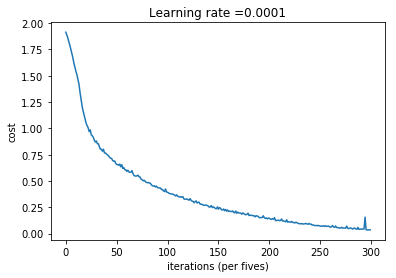

Parameters have been trained!
Train Accuracy: 0.999074
Test Accuracy: 0.716667


In [30]:
parameters = model(X_train, Y_train, X_test, Y_test)

Your algorithm predicts: y = 5


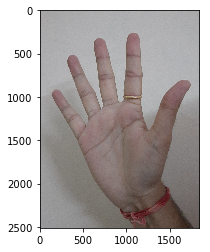

In [40]:
import scipy
from PIL import Image
from scipy import ndimage

# You can also use your own image. Drop down your image in image folder. 
my_image = "ef.jpg"

# We preprocess your image to fit your algorithm.
fname = "images/" + my_image
image = np.array(ndimage.imread(fname, flatten=False))
image = image/255.
my_image = scipy.misc.imresize(image, size=(64,64)).reshape((1, 64*64*3)).T
my_image_prediction = predict(my_image, parameters)

plt.imshow(image)
print("Your algorithm predicts: y = " + str(np.squeeze(my_image_prediction)))